In [2]:
import xarray as xr, numpy as np, pandas as pd, glob, os, re
import regionmask, geopandas as gpd

# from xclim.core.units import convert_units_to

In [ ]:
sf = gpd.read_file("sf_mx-gulfcoast/")

# Daily time series

## CORDEX

In [3]:
fl = glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/cordex/*.nc")

In [47]:
for fnm in fl:

    new_fnm = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/"+re.sub("pr", "pr-ts", fnm.split("/")[-1])

    print(new_fnm)
    if os.path.exists(new_fnm):
        continue

    ds = xr.open_dataset(fnm).pr
    rm = regionmask.mask_geopandas(sf, ds.lon, ds.lat)

    if "rlat" in ds.dims:
        xdim, ydim = ["rlat", "rlon"]
    elif "x" in ds.dims:
        xdim, ydim = ["y","x"]

    ts = ds.where(rm == 0, drop = True).mean([xdim, ydim])
    ts = ts.convert_calendar(calendar = "standard", align_on = "day")

    ts.to_netcdf(new_fnm)

/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/pr-ts_CAM-22_HadGEM2-ES_r1i1p1_RegCM4-7_19700101-20691230.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/pr-ts_CAM-22_NorESM1-M_r1i1p1_REMO2015_19700101-20701231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/pr-ts_CAM-44_MPI-ESM-LR_r1i1p1_REMO2015_19700101-20701231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/pr-ts_CAM-44_HadGEM2-ES_r1i1p1_REMO2015_19700101-20701230.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/pr-ts_CAM-44_CSIRO-Mk3-6-0_r1i1p1_RCA4_19510101-20701231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/pr-ts_CAM-44_GFDL-ESM2M_r1i1p1_RCA4_19510101-20701231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/pr-ts_CAM-22_HadGEM2-ES_r1i1p1_REMO2015_19700101-20701230.nc
/rds/general/user/cb2714/home/00_WWA_project_fo

## HighResMIP

In [76]:
fl = glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/highresmip/*.nc")

In [4]:
for fnm in fl:

    new_fnm = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/ts-daily/"+re.sub("pr", "pr-ts", fnm.split("/")[-1])

    print(new_fnm)
    if os.path.exists(new_fnm):
        continue

    ds = xr.open_dataset(fnm).pr
    rm = regionmask.mask_geopandas(sf, ds.lon, ds.lat)

    xdim, ydim = ["lat", "lon"]

    ts = ds.where(rm == 0, drop = True).mean([xdim, ydim])
    ts = ts.convert_calendar(calendar = "standard", align_on = "day")

    ts.to_netcdf(new_fnm)

/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/ts-daily/pr-ts_CAM-22_HadGEM2-ES_r1i1p1_RegCM4-7_19700101-20691230.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/ts-daily/pr-ts_CAM-22_NorESM1-M_r1i1p1_REMO2015_19700101-20701231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/ts-daily/pr-ts_CAM-44_MPI-ESM-LR_r1i1p1_REMO2015_19700101-20701231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/ts-daily/pr-ts_CAM-44_HadGEM2-ES_r1i1p1_REMO2015_19700101-20701230.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/ts-daily/pr-ts_CAM-44_CSIRO-Mk3-6-0_r1i1p1_RCA4_19510101-20701231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/ts-daily/pr-ts_CAM-44_GFDL-ESM2M_r1i1p1_RCA4_19510101-20701231.nc
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/ts-daily/pr-ts_CAM-22_HadGEM2-ES_r1i1p1_REMO2015_19700

## Annual time series

In [13]:
fl = glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mexico-floods/ts-daily/*.nc")

for fnm in fl:

    new_fnm = "ts/pr-jjaso_"+"_".join(fnm.split("/")[-1].split("_")[1:])
    # if os.path.exists(new_fnm): continue
    
    ts = xr.open_dataset(fnm).pr

    if ts.max() < 1:
        ts = (ts * 86400).assign_attrs(units = "mm/day")

    ts_jjaso = ts.sel(time = ts.time.dt.month.isin([6,7,8,9,10])).resample(time = "YS").mean()
    df_jjaso = ts_jjaso.assign_coords(time = ts_jjaso.time.dt.year).rename(time = "year").to_dataframe()
    df_jjaso.to_csv(new_fnm, sep = " ")

    tx_rx3 = ts.rolling(time = 3).sum().resample(time = "YS").max()
    df_rx3 = tx_rx3.assign_coords(time = tx_rx3.time.dt.year).rename(time = "year").to_dataframe()
    df_rx3.to_csv(re.sub("jjaso", "rx3day", new_fnm), sep = " ")

<Axes: xlabel='year'>

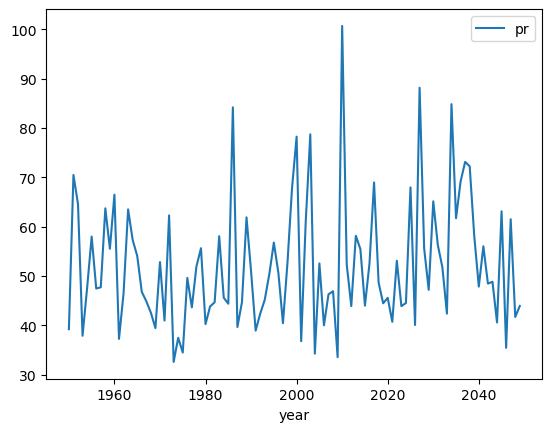